### Get Uniprot Ids for all fDOG-Assembly seed genes

1) open PhyloProfile output, grep all the possible seed gene Ids. That would be all genes from species human, C.elegans or Drosophila
2) open mapping file from OMA version dec 21
3) create dictionary
4) map all the seed gene ids to Uniprot Ids
5) write output mapping file

In [1]:
def get_seed_genes(path, reference_species):
    file = open(path, 'r')
    lines = file.readlines()
    species_set = set()
    gene_vs_oma_dict = {}
    oma_vs_gene_dict = {}
    for i in reference_species:
        species_set.add('ncbi' + str(i))
    for line in lines:
        line = line.rstrip()
        groupId, species, ortho, fasf, fasb = line.split('\t')
        if species in species_set:
            geneId = ortho.split('|')[2]
            protein_set_name = ortho.split('|')[1]
            if protein_set_name.split('@')[2] == '2209':
                oma_vs_gene_dict[groupId] = geneId
                gene_vs_oma_dict[geneId] = groupId
    return oma_vs_gene_dict, gene_vs_oma_dict
        
    

In [2]:
species = [9606, 7227, 6239]
oma_vs_gene_dict, gene_vs_oma_dict = get_seed_genes('../augustus/metazoa_core_augustus.phyloprofile', species)

In [3]:
def parse_mapping_file(path):
    file = open(path, 'r')
    lines = file.readlines()
    oma_vs_uniprot_dict = {}
    for line in lines:
        line = line.rstrip()
        if line.startswith('#'):
            continue
        else:
            gene, uniprot = line.split('\t')
            oma_vs_uniprot_dict[gene] = uniprot
    return oma_vs_uniprot_dict

In [4]:
path = '../../data/oma_dec_21/oma-uniprot.txt'
oma_vs_uniprot = parse_mapping_file(path)

In [5]:
def mapping(oma_vs_uniprot, gene_vs_oma_dict):
    gene_list = []
    human = 0
    caeel = 0
    drome = 0
    for gene in gene_vs_oma_dict:
        if gene.startswith('HUMAN'):
            human += 1
        elif gene.startswith('CAEEL'):
            caeel += 1
        elif gene.startswith('DROME'):
            human += 1
        else:
            print(gene)
        try:
            gene_list.append(gene_vs_oma_dict[gene] + '\t' + oma_vs_uniprot[gene])
        except KeyError:
            print(gene)
    print('Human %s, Caeel %s, Drome %s'%(human, caeel, drome))
    return gene_list

In [6]:
group_vs_uniprot = mapping(oma_vs_uniprot, gene_vs_oma_dict)

HUMAN22299
HUMAN24900
HUMAN80254
Human 1396, Caeel 1, Drome 0


I used the UniProt peptide search to find similar human proteins:

HUMAN80254: Q8NI36, A0A0A0MTB8

HUMAN24900: Q7L5Y6, Q7L5Y6-2

HUMAN22299: P26440, A0A0A0MT83

Information from UniProt: Peptide search -> search with a peptide seqeunce to find all UniProt proteins that contain exact matches

In [7]:
out = open('../../data/fDOG-assembly/seed_vs_uniprot.tsv', 'w')
for i in group_vs_uniprot:
    out.write(i + '\n')
out.close()

### Grep representatives per BUSCO group and map them against uniprot

1) get BUSCO gene IDs of species humna, C. elegans and Drosophila if available per BUSCO group
2) grep gene ID from ogs.id.info
3) map the gene ids against Uniprot by using the orthoDb v10.1 mapping table


In [8]:
def get_representatives(path, species_list):
    # the orthoDB gene ids have the following format: taxid_version:geneID
    file = open(path, 'r')
    lines = file.readlines()
    rep = set()
    species_set = set(species_list)
    print(species_set)
    orthoDB_groups = set()
    orthoGroup_vs_geneId = {}
    geneId_vs_orthoGroup = {}
    for line in lines:
        line = line.rstrip()
        gene_id, buscoGroup = line.split('\t')
        orthoDB_groups.add(buscoGroup)
        species = gene_id.split('_')[0]
        if int(species) in species_set:
            rep.add(gene_id)
            orthoGroup_vs_geneId[buscoGroup] = gene_id
            geneId_vs_orthoGroup[gene_id] = buscoGroup
    
    return rep, orthoGroup_vs_geneId, geneId_vs_orthoGroup, orthoDB_groups
    

In [9]:
species = [9606, 7227, 6239]
path = '../../data/busco/busco_downloads/lineages/metazoa_odb10/info/ogs.id.info'
rep, orthoGroup_vs_geneId, geneId_vs_orthoGroup, orthoDB_groups = get_representatives(path, species)
print(len(rep))

human = 0
human_set = set()
caeel = 0
drome = 0
drome_set = set()
for i in rep:
    if i.startswith('9606'):
        human += 1
        try:
            human_set.add(geneId_vs_orthoGroup[i])
        except KeyError:
            pass
    elif i.startswith('7227'):
        drome += 1
        try:
            drome_set.add(geneId_vs_orthoGroup[i])
        except KeyError:
            pass
    elif i.startswith('6239'):
        caeel += 1
print('Human %s, Caeel %s, Drome %s'%(human, caeel, drome))

print('Human set %i, Drome set %i, Intersection %i, Difference %i'%(len(human_set), len(drome_set), len(drome_set.intersection(human_set)), len((drome_set - human_set)) + len((human_set - drome_set))))



{7227, 9606, 6239}
1865
Human 938, Caeel 0, Drome 927
Human set 938, Drome set 927, Intersection 912, Difference 41


In [10]:
def create_mapping_dicts_orthodb_uniprot(path, rep):
    file = open(path, 'r')
    lines = file.readlines()
    orthodb_vs_uniprot_dict = {}
    for line in lines:
        line = line.rstrip()
        row = line.split('\t')
        try:
            uniprot = row[4]
        except IndexError:
            if len(row) > 4:
                print(row)
        if uniprot != '':
            orthodb_vs_uniprot_dict[row[0]] = uniprot
    return orthodb_vs_uniprot_dict

In [11]:
path = '../../data/busco/orthodb_downloads/odb10v1_genes.tab'
orthodb_vs_uniprot_dict = create_mapping_dicts_orthodb_uniprot(path, rep)

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

938
927
912


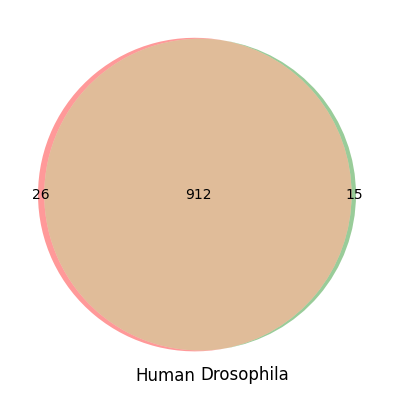

{'366124at33208'}


In [13]:
only_human = human_set - drome_set
only_drome = drome_set - human_set
intersection = len(drome_set.intersection(human_set))
print (len(human_set))
print(len(drome_set))
print(intersection)
venn2(subsets = (len(only_human), len(only_drome), intersection), set_labels = ('Human', 'Drosophila'))
plt.show()

#954 groups would have been possible, that means that we don't have a representative gene for one group 

missing = orthoDB_groups - (human_set.union(drome_set))
print(missing)

### Overlap between BUSCO and OMA core groups

In [14]:
busco = set()
for key in orthodb_vs_uniprot_dict:
    busco.add(orthodb_vs_uniprot_dict[key])

intersection_busco_oma = set()
for i in group_vs_uniprot:
    group, uniprot = i.split('\t')
    if uniprot in busco:
        intersection_busco_oma.add(uniprot)
        
print(len(intersection_busco_oma))



576


In [ ]:
#write to file


### Overlap with human protein set UniProt

In [16]:
human_proteom = set()

path = '../../data/qfo_eukaryota_2022/human_uniprot_ids_qfo22.txt'
file = open(path, 'r')
lines = file.readlines()

for line in lines:
    line = line.rstrip()
    human_proteom.add(line)
    
intersection_proteom_core_groups = human_proteom.intersection(intersection_busco_oma)
print(len(human_proteom))
print(len(intersection_proteom_core_groups))

20598
388


In [17]:
print(intersection_busco_oma - human_proteom)

{'E5KTM5', 'A0A0S2Z410', 'A0A024RE05', 'A0A024R0E3', 'A8K3L7', 'A0A090N8Y5', 'A0A024R811', 'A0MNP2', 'A4D2J0', 'Q94523', 'Q9XVE9', 'A0A024R9L1', 'A0A024R745', 'A0A0S2Z3L0', 'A0A087WT15', 'A0A0S2Z3A9', 'A8YXX4', 'A0A024R157', 'A0A0D9SG71', 'A0A0S2Z4Y5', 'A0A024R6B9', 'A9UGY9', 'A0A024R4K3', 'A8K2M0', 'A0A024R061', 'A0A024RD82', 'G3V1J5', 'A0A024R6H1', 'A8KA82', 'A0A140VKC1', 'A0A140VK45', 'A0A024R9H2', 'A0A024R045', 'A0A024R3X4', 'A0A140VK49', 'A0A024RBC7', 'A0A0S2Z612', 'Q9VIK1', 'J3KTE4', 'A0A024RBY9', 'E5KNU5', 'A0A024RBJ3', 'A0A024R1U2', 'A0A024R292', 'A0A0S2Z4J1', 'A0A024R8B7', 'A0A024RBA9', 'P55162', 'Q9W3T9', 'A0A087WTB8', 'A0A024R9R3', 'A0A0S2Z4J6', 'A4D0V4', 'E2QD65', 'A0A024R625', 'A0A024R565', 'A0A024RBM8', 'A0A024R179', 'A0A090N7W4', 'A0A024R8R4', 'Q9VRP2', 'A0A140VKB3', 'A0A024RAS3', 'A0A140VKB7', 'A0A0S2A4E4', 'A0A024R6G4', 'A8K4H7', 'K7ESL1', 'A0A024RDL1', 'A0A024RDG8', 'Q5TDG3', 'A0MNN4', 'Q9V831', 'A0A140VKE7', 'A0A140VK56', 'A0A024R3H8', 'A0A140VK29', 'A0A024R8S5', 'A0